In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import roc_curve

C:\Users\olata\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load Data

In [2]:
patient_data= pd.read_csv('./Assignment_Data.csv')

## Data Exploration

In [3]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               200 non-null    int64 
 1   age                      200 non-null    int64 
 2   gender                   200 non-null    object
 3   diagnosis_code           200 non-null    object
 4   num_previous_admissions  200 non-null    int64 
 5   medication_type          200 non-null    object
 6   length_of_stay           200 non-null    int64 
 7   readmitted_30_days       200 non-null    int64 
 8   discharge_note           200 non-null    object
dtypes: int64(5), object(4)
memory usage: 14.2+ KB


In [4]:
patient_data.head()

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note
0,1,71,Male,D002,3,Type C,2,0,Good recovery trajectory. Follow-up scan sched...
1,2,34,Female,D002,1,Type B,3,1,Stable post-surgery. Advised to avoid physical...
2,3,80,Male,D002,2,Type C,5,1,Symptoms controlled. Monitoring for relapse ad...
3,4,40,Female,D002,2,Type C,11,0,Stable post-surgery. Advised to avoid physical...
4,5,43,Female,D001,1,Type C,8,1,Stable post-surgery. Advised to avoid physical...


#### Check for Missing Values:

In [5]:
patient_data.isnull().sum()

patient_id                 0
age                        0
gender                     0
diagnosis_code             0
num_previous_admissions    0
medication_type            0
length_of_stay             0
readmitted_30_days         0
discharge_note             0
dtype: int64

#### Readmittance Distribution:

In [6]:
patient_data['readmitted_30_days'].value_counts(normalize=True)*100

0    67.5
1    32.5
Name: readmitted_30_days, dtype: float64

#### Age Distribution:

<IPython.core.display.Javascript object>


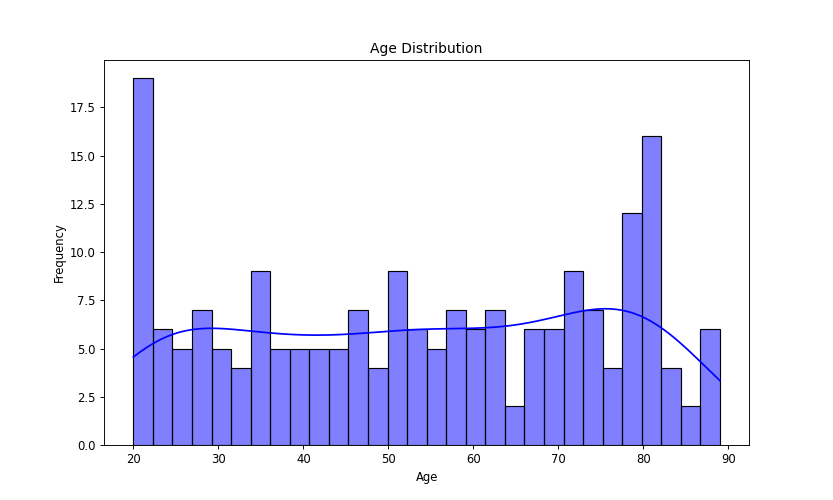

In [7]:
plt.figure(figsize=(10,6))
sns.histplot(patient_data['age'].dropna(), bins=30, kde=True, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

#### Diagnosis Distribution:

In [8]:
patient_data['diagnosis_code'].value_counts(normalize=True)*100

D001    28.0
D002    27.0
D004    26.5
D003    18.5
Name: diagnosis_code, dtype: float64

#### Medication Type Distribution:

In [9]:
patient_data['medication_type'].value_counts(normalize=True)*100

Type B    34.5
Type A    33.5
Type C    32.0
Name: medication_type, dtype: float64

#### Length of Stay Distribution:

In [10]:
patient_data['length_of_stay'].value_counts(normalize=True)*100

13    10.5
8      9.5
9      9.0
2      8.5
14     8.5
5      7.5
11     7.5
3      7.0
10     6.5
1      6.0
12     5.5
7      5.0
4      5.0
6      4.0
Name: length_of_stay, dtype: float64

#### Number of Previous Admissions Distribution:

In [11]:
patient_data['num_previous_admissions'].value_counts(normalize=True)*100

2    29.0
1    28.0
0    22.5
3    12.5
4     4.5
5     2.5
6     1.0
Name: num_previous_admissions, dtype: float64

#### Exploring how Age and Gender contributes to Readmission:

<IPython.core.display.Javascript object>


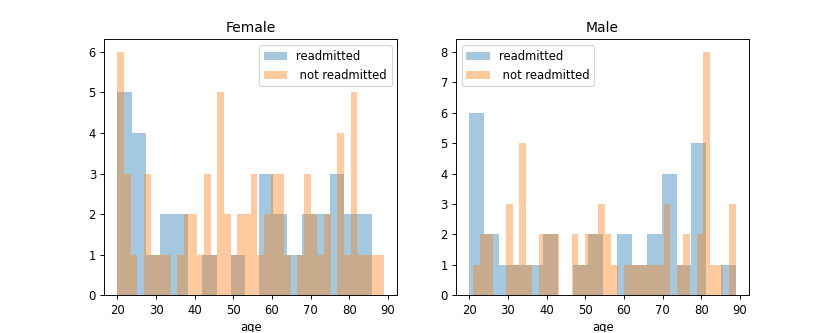

C:\Users\olata\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [12]:
readmitted = 'readmitted'
not_readmitted =' not readmitted'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
female = patient_data[patient_data['gender']=='Female']
male = patient_data[patient_data['gender']=='Male']
ax = sns.distplot(female[female['readmitted_30_days']==1].age.dropna(), bins=18, label = readmitted, ax = axes[0], kde =False)
ax = sns.distplot(female[female['readmitted_30_days']==0].age.dropna(), bins=40, label = not_readmitted, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(male[male['readmitted_30_days']==1].age.dropna(), bins=18, label = readmitted, ax = axes[1], kde = False)
ax = sns.distplot(male[male['readmitted_30_days']==0].age.dropna(), bins=40, label = not_readmitted, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')


#### Exploring how Gender, Diagnosis, Medication Type, Length of Stay and No. Of Previous Admissions fields and relationship to Readmission within 30 days:

<IPython.core.display.Javascript object>


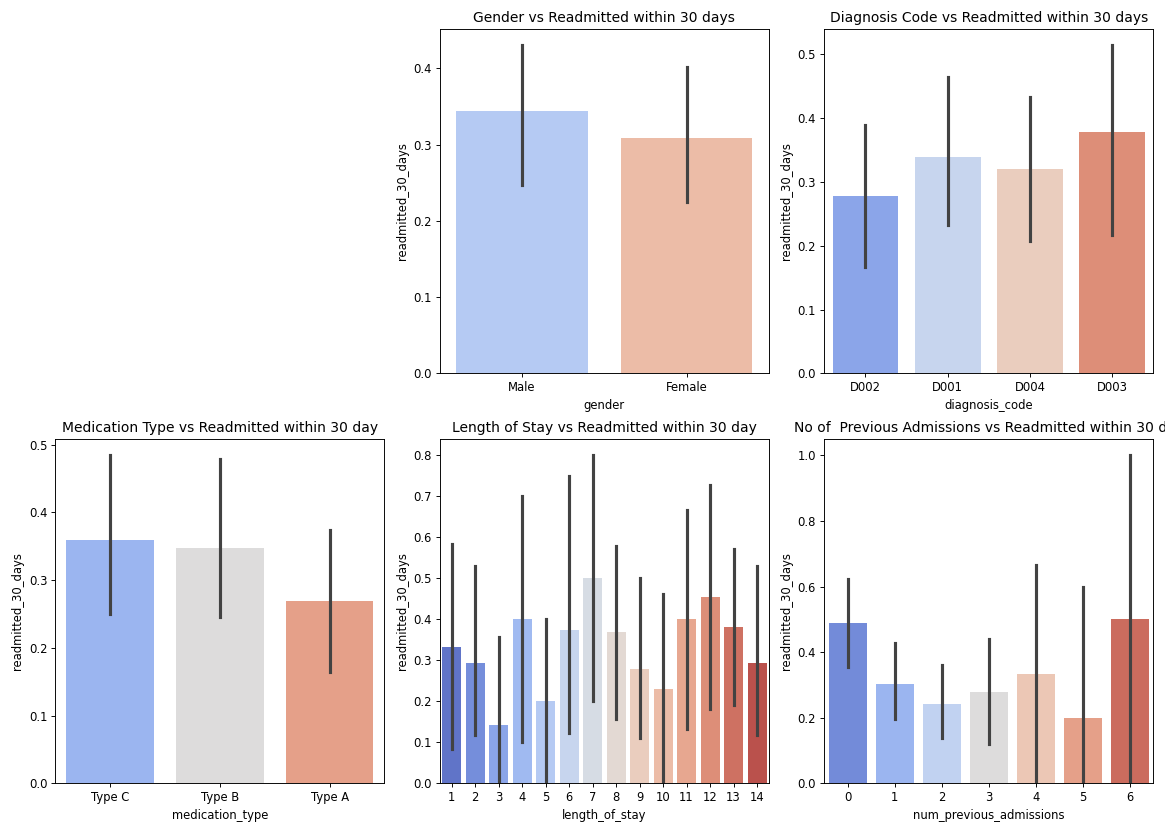

In [13]:
plt.figure(figsize=(14, 10))

# Plot: Sex vs Readmittance within 30 days
plt.subplot(2, 3, 2)
sns.barplot(x='gender', y='readmitted_30_days', data=patient_data, palette='coolwarm')
plt.title('Gender vs Readmitted within 30 days')

# Plot: Diagnosis Code vs Readmittance within 30 days
plt.subplot(2, 3, 3)
sns.barplot(x='diagnosis_code', y='readmitted_30_days', data=patient_data, palette='coolwarm')
plt.title('Diagnosis Code vs Readmitted within 30 days')

# Plot: Medication Type vs Readmittance within 30 days
plt.subplot(2, 3, 4)
sns.barplot(x='medication_type', y='readmitted_30_days', data=patient_data, palette='coolwarm')
plt.title('Medication Type vs Readmitted within 30 day')

# Plot: Length of Stay Code vs Readmittance within 30 days
plt.subplot(2, 3, 5)
sns.barplot(x='length_of_stay', y='readmitted_30_days', data=patient_data, palette='coolwarm')
plt.title('Length of Stay vs Readmitted within 30 day')

# Plot: No Previous Admissions vs Readmittance within 30 days
plt.subplot(2, 3, 6)
sns.barplot(x='num_previous_admissions', y='readmitted_30_days', data=patient_data, palette='coolwarm')
plt.title('No of  Previous Admissions vs Readmitted within 30 day')

# Adjust layout
plt.tight_layout()
plt.show()

#### Examining Outliers:

<IPython.core.display.Javascript object>


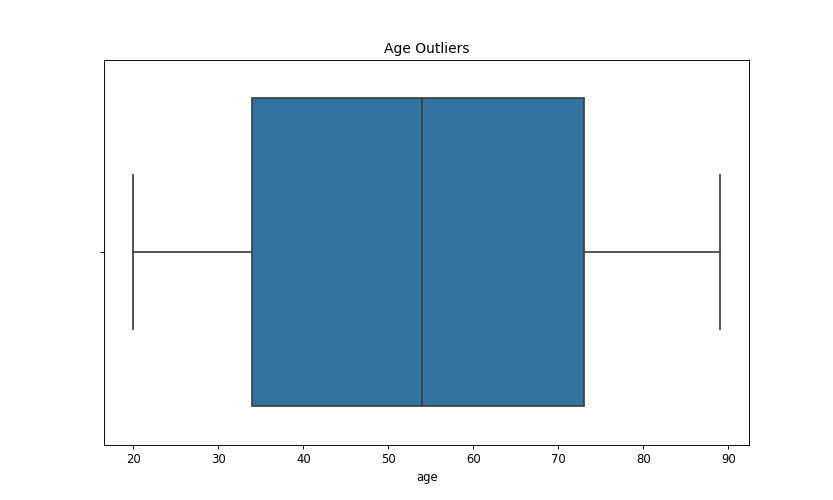

In [14]:
plt.figure(figsize=(10,6))
sns.boxplot(x=patient_data['age'])
plt.title('Age Outliers')
plt.show()


<IPython.core.display.Javascript object>


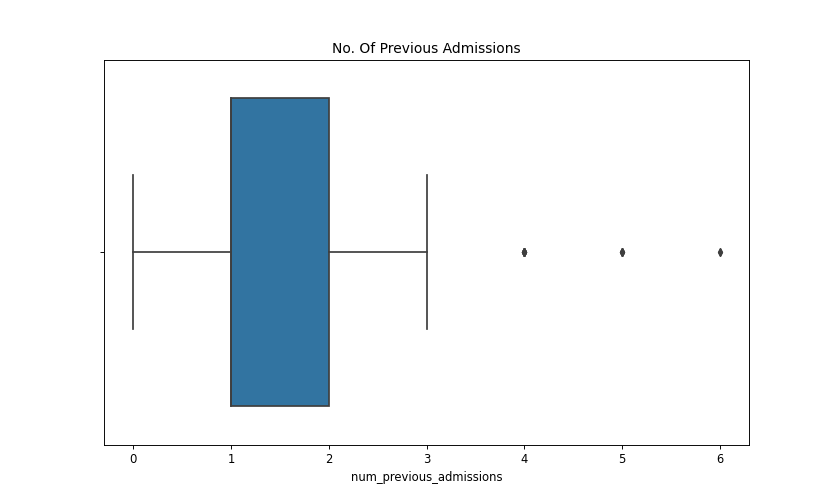

In [15]:
plt.figure(figsize=(10,6))
sns.boxplot(x=patient_data['num_previous_admissions'])
plt.title('No. Of Previous Admissions')
plt.show()

<IPython.core.display.Javascript object>


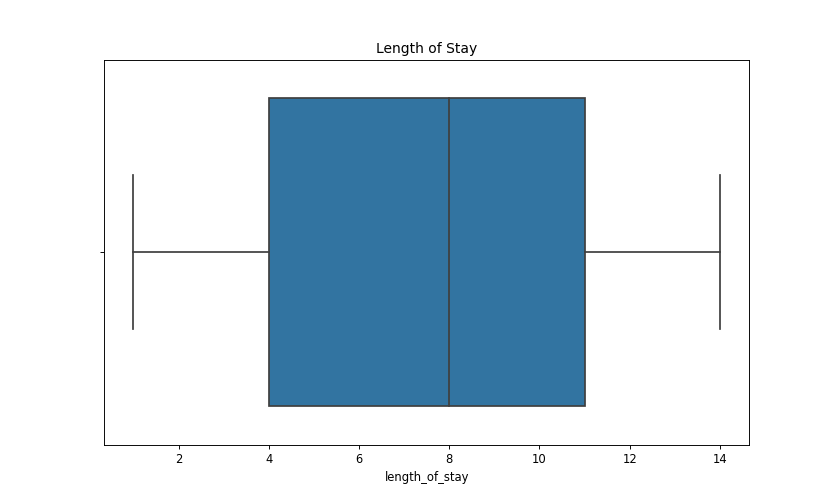

In [16]:
plt.figure(figsize=(10,6))
sns.boxplot(x=patient_data['length_of_stay'])
plt.title('Length of Stay')
plt.show()

## Data Preprocessing

In [17]:
patient_data

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note
0,1,71,Male,D002,3,Type C,2,0,Good recovery trajectory. Follow-up scan sched...
1,2,34,Female,D002,1,Type B,3,1,Stable post-surgery. Advised to avoid physical...
2,3,80,Male,D002,2,Type C,5,1,Symptoms controlled. Monitoring for relapse ad...
3,4,40,Female,D002,2,Type C,11,0,Stable post-surgery. Advised to avoid physical...
4,5,43,Female,D001,1,Type C,8,1,Stable post-surgery. Advised to avoid physical...
...,...,...,...,...,...,...,...,...,...
195,196,50,Male,D001,6,Type A,8,0,Good recovery trajectory. Follow-up scan sched...
196,197,61,Female,D004,1,Type B,2,0,Patient discharged with minor discomfort. Advi...
197,198,26,Male,D002,0,Type C,8,0,Discharge after recovery from pneumonia. No co...
198,199,35,Female,D001,3,Type C,11,1,Blood pressure under control. Continue current...


#### Covert Free Text From Discharge Into Encoded Categories:

In [18]:
vectorizer = CountVectorizer(tokenizer=lambda x: x.split('.'))
matrix = vectorizer.fit_transform(patient_data['discharge_note'])
df = pd.DataFrame(data= matrix.toarray(), columns = vectorizer.get_feature_names_out())
df

,,advised rest and hydration,advised to avoid physical exertion,continue current medication,follow-up scan scheduled next month,monitoring for relapse advised,no complications observed,prescribed antibiotics for 5 days,recommend follow-up in 2 weeks,resume normal diet and activity,...,blood pressure under control,discharge after recovery from pneumonia,good recovery trajectory,mild reaction to medication,no further signs of infection,patient discharged in stable condition,patient discharged with minor discomfort,patient showed improvement,stable post-surgery,symptoms controlled
0,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
196,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
197,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
198,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [19]:
# join vectorised data to main data
v_patient_data = patient_data.join(df)
patient_data = v_patient_data

In [20]:
patient_data.head()

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note,,...,blood pressure under control,discharge after recovery from pneumonia,good recovery trajectory,mild reaction to medication,no further signs of infection,patient discharged in stable condition,patient discharged with minor discomfort,patient showed improvement,stable post-surgery,symptoms controlled
0,1,71,Male,D002,3,Type C,2,0,Good recovery trajectory. Follow-up scan sched...,1,...,0,0,1,0,0,0,0,0,0,0
1,2,34,Female,D002,1,Type B,3,1,Stable post-surgery. Advised to avoid physical...,1,...,0,0,0,0,0,0,0,0,1,0
2,3,80,Male,D002,2,Type C,5,1,Symptoms controlled. Monitoring for relapse ad...,1,...,0,0,0,0,0,0,0,0,0,1
3,4,40,Female,D002,2,Type C,11,0,Stable post-surgery. Advised to avoid physical...,1,...,0,0,0,0,0,0,0,0,1,0
4,5,43,Female,D001,1,Type C,8,1,Stable post-surgery. Advised to avoid physical...,1,...,0,0,0,0,0,0,0,0,1,0


#### Remove unwanted columns:
I will drop patient_id  (because it does not influence 30 day readmittance) and discharge notes as we have derived new features from it:

In [21]:
patient_data = patient_data.drop(['patient_id', 'discharge_note'] , axis=1)

In [22]:
patient_data.head()

,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,,advised rest and hydration,advised to avoid physical exertion,...,blood pressure under control,discharge after recovery from pneumonia,good recovery trajectory,mild reaction to medication,no further signs of infection,patient discharged in stable condition,patient discharged with minor discomfort,patient showed improvement,stable post-surgery,symptoms controlled
0,71,Male,D002,3,Type C,2,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,34,Female,D002,1,Type B,3,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
2,80,Male,D002,2,Type C,5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,40,Female,D002,2,Type C,11,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
4,43,Female,D001,1,Type C,8,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0


####  Encoding Categorical Variables:

###### Gender Conversion:

In [23]:
data = [patient_data]
genders = {"Male": 0, "Female": 1}

for dataset in data:
    dataset['gender'] = dataset['gender'].map(genders)
    
dataset.head()

,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,,advised rest and hydration,advised to avoid physical exertion,...,blood pressure under control,discharge after recovery from pneumonia,good recovery trajectory,mild reaction to medication,no further signs of infection,patient discharged in stable condition,patient discharged with minor discomfort,patient showed improvement,stable post-surgery,symptoms controlled
0,71,0,D002,3,Type C,2,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,34,1,D002,1,Type B,3,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
2,80,0,D002,2,Type C,5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,40,1,D002,2,Type C,11,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
4,43,1,D001,1,Type C,8,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0


###### Diagnosis Code Conversion:

In [24]:
data = [patient_data]
diagnosis_codes = {"D001": 0, "D002": 1, "D003": 2, "D004": 3}

for dataset in data:
    dataset['diagnosis_code'] = dataset['diagnosis_code'].map(diagnosis_codes)
    
dataset.head()

,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,,advised rest and hydration,advised to avoid physical exertion,...,blood pressure under control,discharge after recovery from pneumonia,good recovery trajectory,mild reaction to medication,no further signs of infection,patient discharged in stable condition,patient discharged with minor discomfort,patient showed improvement,stable post-surgery,symptoms controlled
0,71,0,1,3,Type C,2,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,34,1,1,1,Type B,3,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
2,80,0,1,2,Type C,5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,40,1,1,2,Type C,11,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
4,43,1,0,1,Type C,8,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0


###### Medication Type Conversion:

In [25]:
data = [patient_data]
medication_types = {"Type A": 0, "Type B": 1, "Type C": 2}

for dataset in data:
    dataset['medication_type'] = dataset['medication_type'].map(medication_types)
    
dataset.head()

,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,,advised rest and hydration,advised to avoid physical exertion,...,blood pressure under control,discharge after recovery from pneumonia,good recovery trajectory,mild reaction to medication,no further signs of infection,patient discharged in stable condition,patient discharged with minor discomfort,patient showed improvement,stable post-surgery,symptoms controlled
0,71,0,1,3,2,2,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,34,1,1,1,1,3,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
2,80,0,1,2,2,5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,40,1,1,2,2,11,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
4,43,1,0,1,2,8,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0


####  Dependent (Target) and Independent Variable

In [26]:
X = patient_data.drop('readmitted_30_days', axis = 1)
y = patient_data['readmitted_30_days']

In [27]:
X


,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,,advised rest and hydration,advised to avoid physical exertion,continue current medication,...,blood pressure under control,discharge after recovery from pneumonia,good recovery trajectory,mild reaction to medication,no further signs of infection,patient discharged in stable condition,patient discharged with minor discomfort,patient showed improvement,stable post-surgery,symptoms controlled
0,71,0,1,3,2,2,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,34,1,1,1,1,3,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,80,0,1,2,2,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,40,1,1,2,2,11,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,43,1,0,1,2,8,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,50,0,0,6,0,8,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
196,61,1,3,1,1,2,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
197,26,0,1,0,2,8,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
198,35,1,0,3,2,11,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0


####  Split data into training and testing

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((160, 27), (40, 27))

## Model Training - Random Forest

#### Standard Random Forest:

In [29]:
rf = RandomForestClassifier(n_estimators=200,  random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Standard Random Forest Accuracy: {acc_rf:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Standard Random Forest Accuracy: 0.65

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.86      0.77        28
           1       0.33      0.17      0.22        12

    accuracy                           0.65        40
   macro avg       0.52      0.51      0.50        40
weighted avg       0.59      0.65      0.61        40


Confusion Matrix:
[[24  4]
 [10  2]]


#### Tune hyperparameters with Randomized Search CV:

In [30]:
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                                   n_iter=100, cv=5, n_jobs=-1, verbose=2)
random_search.fit(X_train, y_train)

best_rf_model = random_search.best_estimator_
print("Best Estimator:", best_rf_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Estimator: RandomForestClassifier(max_features='sqrt', min_samples_leaf=8,
                       min_samples_split=8, n_estimators=188, random_state=42)


#### Retrain with new parameters:

In [31]:
rf = RandomForestClassifier(max_depth=20, min_samples_leaf=7, min_samples_split=5,
                       n_estimators=51, random_state=42)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f" Optimised - Standard Random Forest Accuracy: {acc_rf:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

 Optimised - Standard Random Forest Accuracy: 0.72

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        28
           1       0.67      0.17      0.27        12

    accuracy                           0.73        40
   macro avg       0.70      0.57      0.55        40
weighted avg       0.71      0.72      0.66        40


Confusion Matrix:
[[27  1]
 [10  2]]


#### Feature Importance:

In [32]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

In [33]:
importances.head(15)

,importance
feature,
age,0.231
length_of_stay,0.160
num_previous_admissions,0.116
continue current medication,0.097
medication_type,0.078
blood pressure under control,0.077
diagnosis_code,0.053
patient discharged with minor discomfort,0.030
no further signs of infection,0.025


<IPython.core.display.Javascript object>


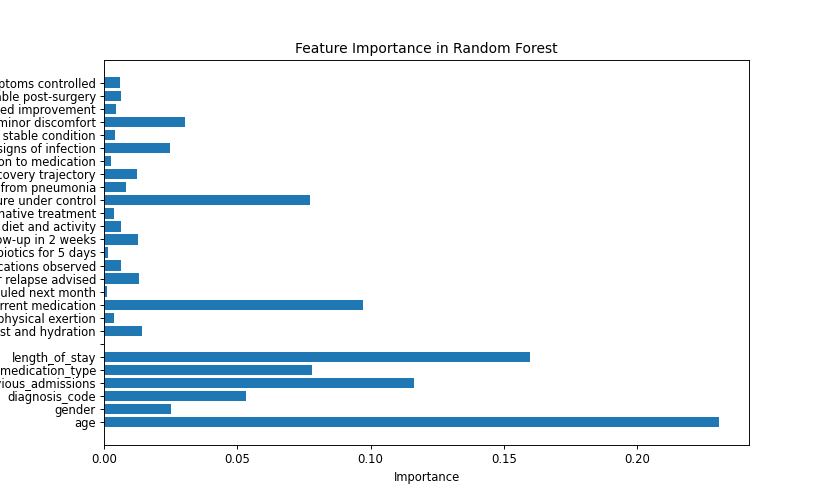

In [34]:
# Plot the feature importance
feature_importance = rf.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importance)
plt.title("Feature Importance in Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

#### ROC AUC:

In [35]:
y_scores = rf.predict_proba(X_train)
y_scores = y_scores[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_scores)

<IPython.core.display.Javascript object>


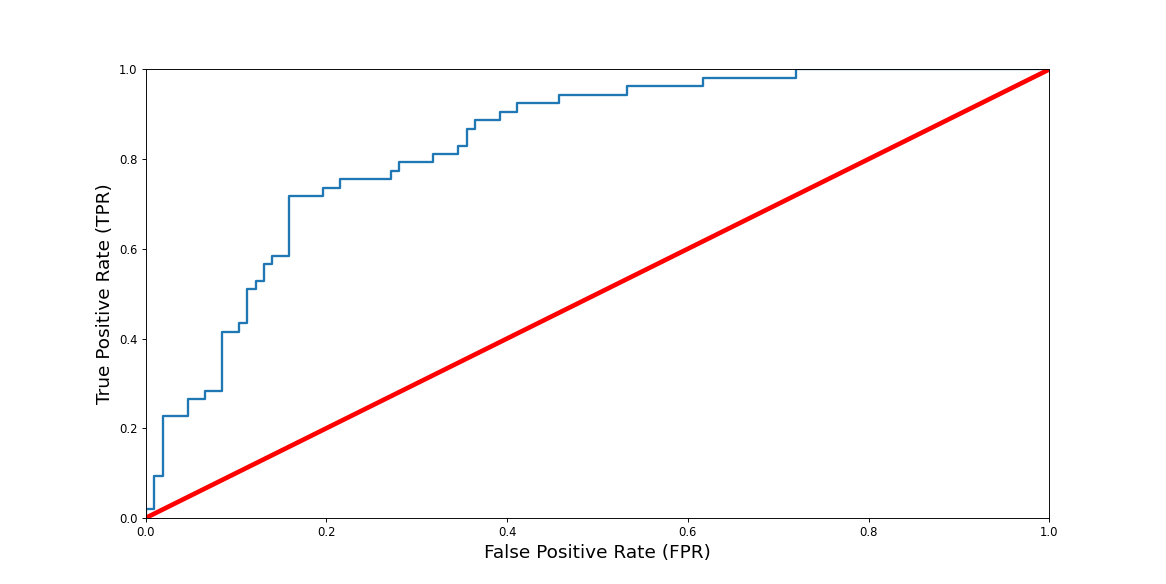

In [36]:
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [37]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.8314230294480691
